# Linear model for wind-driven circulation
In this notebook, we calculate linear model estimates given by
$$
\oint_{C(H)} {\mathbf{u}}_b \cdot \hat{\mathbf{t}}\,dl = e^{-\frac{R}{D}t}\oint_{C(H)}  \mathbf{u}_b^0 \cdot \hat{\mathbf{t}}\,dl + \int_0^t e^{-\frac{R}{D}\left(t-t'\right)} \frac{1}{H}\oint_{C(H)}\mathbf{\tau}_s \cdot \hat{\mathbf{t}}\,dl \, dt'.
$$

Discretizing, and using a forward Euler scheme, we get

$$
C^n = e^{-\frac{R}{D}n\Delta t} C^0 + \sum_{i=0}^n e^{-\frac{R}{D}(n-i)\Delta t} \Delta t\Tau^i,
$$
where
$$
C^i = \oint_{C(H)} {\mathbf{u}}_b(t_i) \cdot \hat{\mathbf{t}}\,dl \qquad \text{and}\qquad  \Tau^i = \oint_{C(H)}\frac{1}{H}\mathbf{\tau}_s \cdot \hat{\mathbf{t}}\,dl.
$$

In matrix form, this can be expressed as
$$
\mathbf{C} = A\mathbf{\Tau} + \mathbf{b}
$$,
where $\mathbf{C}$ and $\mathbf{\Tau}$ are vectors $\mathbf{C} = [C_0, C_1, \ldots, C_N]^T$ and $\mathbf{\Tau} = [T_0, T_1, \ldots, T_N]^T$, and $A$ and $\mathbf{b}$ are given by 
$$ \mathbf{b} = U⁰\begin{bmatrix}
1 \\
e^{-\frac{R}{D}\Delta t} \\
e^{-2\frac{R}{D}\Delta t} \\
\vdots \\
e^{-n\frac{R}{D}\Delta t} 
\end{bmatrix}, \qquad A= \Delta t\begin{bmatrix}
0 & e^{-\frac{R}{D}\Delta t} & e^{-2\frac{R}{D}\Delta t} & \cdots & e^{-n\frac{R}{D}\Delta t} \\
0 & 1 & e^{-\frac{R}{D}\Delta t} &  & e^{-(n-1)\frac{R}{D}\Delta t} \\
\vdots &  &  &  &  \\
0 & 0 & 0 & 1 & e^{-\frac{R}{D}\Delta t} \\
0 & 0 & 0 & 0 & 1 
\end{bmatrix}$$

We use the matrix equation to calcultae estimates for $C$. The circulation of the surface stress $\Tau$ is taken directly from ROMS-A4. Metods for construction $A$ and $\mathbf{b}$ can be found in [methods_linear_model.py](methods_linear_model.py).

In [6]:
import matplotlib.pyplot as plt
import glob
import xarray as xr
import os

# methods for running the linear model can be found in the file methods_linear_model.py
from methods_linear_model import *

In [7]:
# define parameters
Rs = np.arange(2,151,2)*1e-5   # friction coefficients 
H = 2750                       # mean depth
rho = 1025                     # density, used to calculate kinematic stress
filter_scale = 100000          # filter scale applied to contour
dt = 60*60*24                  # time step in seconds 

figsize=(10,10)

In [8]:
# path where circulatio files are stored. 
circulation_filepath = '../data/circulations/'

# path where calculated estimates will be saved
estimates_path = '../data/estimates/'

# Find all matching files
circulation_files = glob.glob(circulation_filepath+f"*_{H}_{filter_scale}_circ.nc")
circulation_files

['../data/circulations/canadian_2750_100000_circ.nc',
 '../data/circulations/greenland_2750_100000_circ.nc',
 '../data/circulations/norwegian_2750_100000_circ.nc',
 '../data/circulations/eurasian_2750_100000_circ.nc']

In [9]:
# calculate linear model estimates for each R value
for cfile in circulation_files:
    ds = xr.open_dataset(cfile)
    F = ds.circ_tau/(rho*H)
    U0 = ds.circ_ub.isel(time=0).values

    estimates = run_linear_model(F, U0, Rs, H, dt)

    ds["estimates"] = estimates 

    ub = ds.circ_ub.fillna(0).values
    ubar = ds.circ_u.fillna(0).values

    # Calculate Pearson correlation coefficients for each R value
    rs_ub = []
    rs_ubar = []
    for R in ds.R:
        # chose y for correlation calculation. 
        y = ds.sel(R=R).estimates.fillna(0).values
        r_ubar = np.corrcoef(ubar, y)[0,1]
        rs_ubar.append(r_ubar)
        
        r_ub = np.corrcoef(ub, y)[0,1]
        rs_ub.append(r_ub)

    # Store correlation coefficients in the dataset
    rs_ubar = np.array(rs_ubar)
    ds["r_ubar"] = ("R", rs_ubar)

    rs_ub = np.array(rs_ub)
    ds["r"] = ("R", rs_ub)

    outname = estimates_path+cfile[len(circulation_filepath):-7]+"estimates.nc"

    if os.path.exists(outname):
        os.remove(outname)

    ds.to_netcdf(outname)

Text(0.02, 0.5, 'Circulation [cm s-1]')

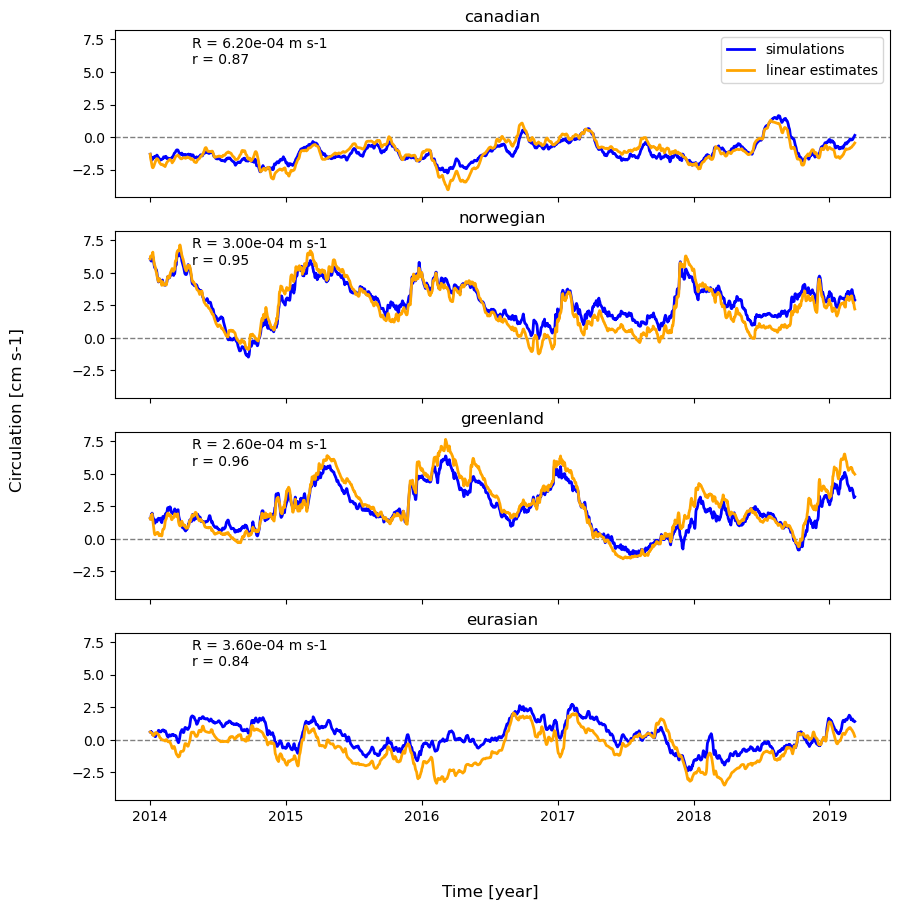

In [10]:
# plot estimate with highest correlation
estimates_files = glob.glob(estimates_path+f"*_{H}_{filter_scale}_estimates.nc")

fig, axes = plt.subplots(nrows = len(estimates_files), figsize=figsize, sharex=True, sharey=True)

for efile, ax in zip(estimates_files, axes.flatten()):
    ds = xr.open_dataset(efile)

    # Find the R value with the maximum correlation coefficient. Can also set R manually
    R = ds.r.idxmax().values

    # Select the dataset for the optimal R value
    dss = ds.sel(R=R)

    r = dss.r.values
    t = dss.time.values

    # Plot 
    ax.axhline(0, lw=1,  ls="--", color="gray")
    ax.plot(t,dss.circ_ub*1e2, label="simulations", color="blue", lw=2)
    #ax.plot(t,ds.circ_u, label="depth-average", color="light blue", lw=2)
    ax.plot(t,dss.estimates*1e2, label="linear estimates", color="orange", lw=2)

    ax.text(0.1, 0.8, f"R = {R:.2e} m s-1\nr = {r:.2f}", transform=ax.transAxes)
    
    title = efile.split("/")[-1].split("_")[0]
    ax.set_title(title)
    
axes.flatten()[0].legend()
fig.supxlabel("Time [year]")
fig.supylabel("Circulation [cm s-1]")